In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()
        # BN-ReLU-Conv(1x1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.drop1 = nn.Dropout2d(p=drop_rate)
        
        # BN-ReLU-Conv(3x3)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop2 = nn.Dropout2d(p=drop_rate)
        
    def forward(self, x):
        new_features = self.conv1(self.relu1(self.bn1(x)))
        new_features = self.drop1(new_features) if self.training else new_features
        new_features = self.conv2(self.relu2(self.bn2(new_features)))
        new_features = self.drop2(new_features) if self.training else new_features
        return torch.cat([x, new_features], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.add_module('denselayer%d' % (i + 1),
                                  DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size, drop_rate))
            
    def forward(self, x):
        features = x
        for layer in self.layers:
            features = layer(features)
        return features

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels, drop_rate=0.2):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.drop = nn.Dropout2d(p=drop_rate)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.drop(x) if self.training else x
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 8), 
                 num_init_features=32, bn_size=4, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        # First convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),  # Initial dropout for input images
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Add a dense block
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            
            # Add a transition layer between dense blocks (except after the last block)
            if i != len(block_config) - 1:
                trans = Transition(in_channels=num_features, out_channels=num_features // 2, drop_rate=drop_rate)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
        
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.features.add_module('drop5', nn.Dropout2d(p=drop_rate))
        
        # Classification layers with dropout
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Higher dropout before final classification
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# Create an instance of the model
model = DenseNet(growth_rate=12, block_config=(6, 12, 8), num_classes=10, drop_rate=0.2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95, weight_decay=0.0005)
# Alternative: optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Load and preprocess data (using your existing setup)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder('../../data/processed/train_augmented_rotated/', transform=transform)
valset = torchvision.datasets.ImageFolder('../../data/raw/valid/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

# Early stopping implementation
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_model = None

    def check(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
            return False
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                # Restore best model
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                    torch.save(model, 'best_model.pth')
                return True
        return False

ES = EarlyStopper(patience=4, min_delta=0)

def train(epochs=5):
    time_started = time.time()
    _train_errors = []
    _val_errors = []
    
    for epoch in range(epochs):
        correct_train = 0
        total = 0
        running_loss = 0.0
        
        epoch_loss = 0.0
        total_batches = 0
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            correct_train += (torch.argmax(outputs, 1) == labels).float().sum().item()
            total += len(outputs)
            
            # Print statistics
            running_loss += loss.item()
            
            epoch_loss += loss.item()
            total_batches += 1
            
            if i % 200 == 199:    # Print every 200 mini-batches
                acc = correct_train / total
                print(f'[{epoch + 1}, {i + 1}], time {time.time() - time_started:.2f}s loss: {running_loss / 200:.3f}, acc: {acc * 100:.2f}%')
                running_loss = 0.0
                
        _train_errors.append(epoch_loss / total_batches)
        val_error = 0
        correct_val = 0
        
        model.eval()
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_error = val_error + criterion(outputs, labels) * images.size(0)
                correct_val += (torch.argmax(outputs, 1) == labels).float().sum().item()
            val_error = val_error / len(valloader.dataset)
            _val_errors.append(val_error)
            print(f'epoch {epoch + 1} TRAIN error: {epoch_loss / total_batches:.4f}, acc: {correct_train/total:.4f}')
            print(f'epoch {epoch + 1} VALIDATION error: {val_error:.4f}, acc: {correct_val/len(valloader.dataset):.4f}')

        if ES.check(val_error, model):
            print('Early stopping triggered!')
            return _train_errors, _val_errors
    
    return _train_errors, _val_errors

In [6]:
train_errors, val_errors = train(1000)

[1, 200], time 11.89s loss: 2.344, acc: 13.09%
[1, 400], time 19.55s loss: 2.235, acc: 14.89%
[1, 600], time 27.20s loss: 2.166, acc: 16.12%
[1, 800], time 34.65s loss: 2.120, acc: 16.91%
[1, 1000], time 42.06s loss: 2.103, acc: 17.57%
[1, 1200], time 49.72s loss: 2.067, acc: 18.30%
[1, 1400], time 57.38s loss: 2.062, acc: 18.59%
[1, 1600], time 64.99s loss: 2.035, acc: 19.07%
[1, 1800], time 72.64s loss: 2.020, acc: 19.48%
[1, 2000], time 80.30s loss: 2.027, acc: 19.77%
[1, 2200], time 87.98s loss: 2.006, acc: 20.09%
[1, 2400], time 95.66s loss: 1.992, acc: 20.37%
[1, 2600], time 103.21s loss: 2.004, acc: 20.64%
[1, 2800], time 110.89s loss: 1.991, acc: 20.86%
[1, 3000], time 118.55s loss: 1.989, acc: 21.06%
[1, 3200], time 126.13s loss: 1.972, acc: 21.31%
[1, 3400], time 133.75s loss: 1.958, acc: 21.51%
[1, 3600], time 141.46s loss: 1.962, acc: 21.69%
[1, 3800], time 149.09s loss: 1.934, acc: 21.86%
[1, 4000], time 156.67s loss: 1.926, acc: 22.10%
[1, 4200], time 164.24s loss: 1.936,

In [10]:
val_errors = [error.item() for error in val_errors]
train_errors = [error.item() for error in train_errors]

AttributeError: 'float' object has no attribute 'item'

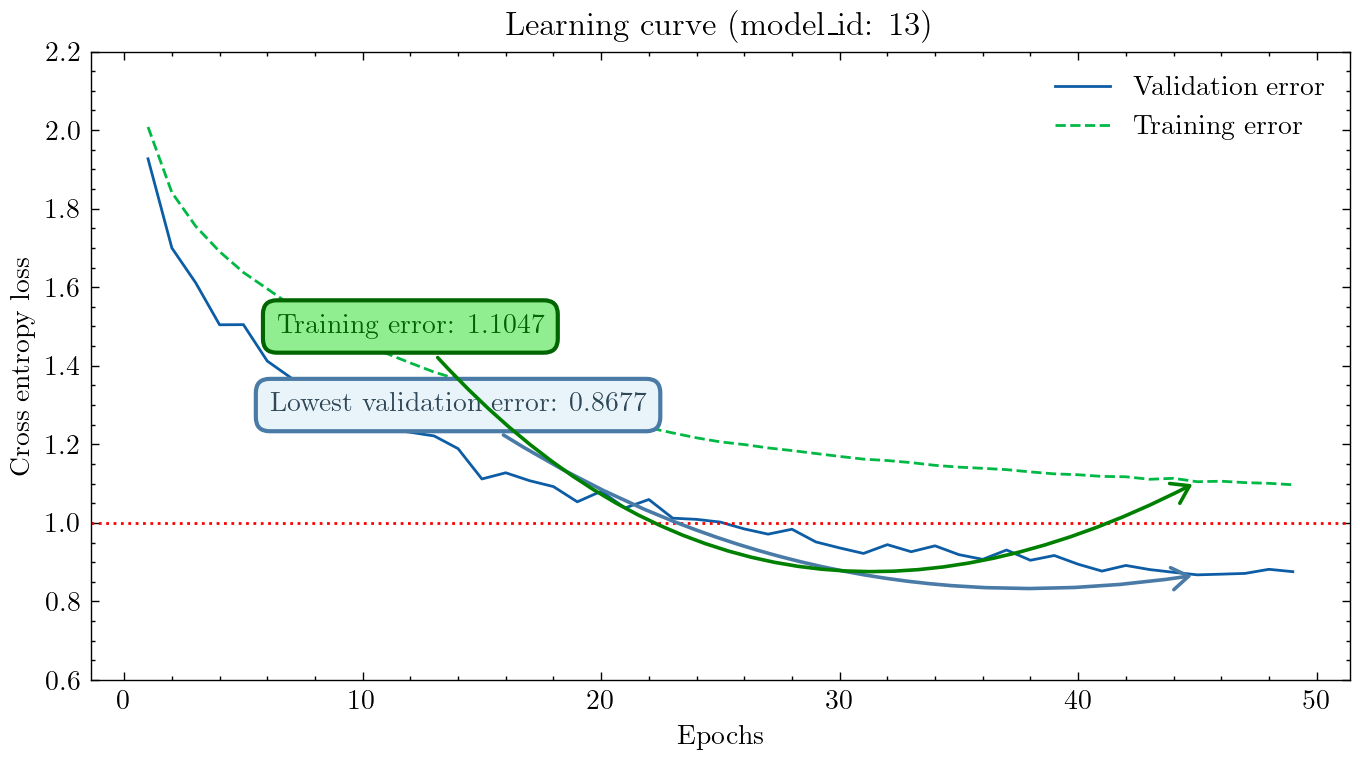

In [14]:
%matplotlib widget
import scienceplots
import matplotlib.pyplot as plt
import numpy as np

with plt.style.context('science'):
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(7, 4))
    
    x = [i + 1 for i in range(len(val_errors))]
    ax.plot(x, val_errors, label="Validation error")
    ax.plot(x, train_errors, linestyle="--", label="Training error")
    
    ax.set_title("Learning curve (model_id: 13)")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cross entropy loss")
    ax.set_ylim([0.6, 2.2])
    ax.axhline(y = 1, color = 'r', linestyle = ':') 
    
    plt.legend()
    
    # Validation error annotation
    argmin_valerror = np.argmin(val_errors) + 1
    val_target_point = (argmin_valerror, val_errors[argmin_valerror-1])
    val_text_position = (14, 1.3)
    
    val_bbox_style = dict(
        boxstyle="round,pad=0.5",
        fc="#E8F4FA",        # Light blue background
        ec="#4A7BA7",        # Medium blue edge
        lw=1.5               # Slightly thicker edge
    )
    
    val_arrow_style = dict(
        arrowstyle="->,head_length=0.6,head_width=0.4",
        color="#4A7BA7",     # Match the box edge color
        connectionstyle="arc3,rad=.2",  # Slightly curved arrow
        lw=1.3               # Slightly thicker arrow
    )
    
    an1 = ax.annotate(
        f"Lowest validation error: {val_errors[argmin_valerror-1]:.4f}", 
        xy=val_target_point,       # Where the arrow points to
        xytext=val_text_position,  # Where the text box starts
        xycoords='data',
        textcoords='data',
        ha="center", va="center",
        fontsize=10,
        fontweight='medium',
        color="#2F4858",       # Dark blue text
        bbox=val_bbox_style,
        arrowprops=val_arrow_style
    )
    
    # Enable the draggable functionality
    an1.draggable()
    
    # Training error annotation
    argmin_trainerror = np.argmin(train_errors) + 1
    train_target_point = (argmin_valerror, train_errors[argmin_valerror-1])
    train_text_position = (12, 1.5)
    
    train_bbox_style = dict(
        boxstyle="round,pad=0.5",
        fc="lightgreen",        # Light orange background
        ec="darkgreen",        # Medium orange edge
        lw=1.5               # Slightly thicker edge
    )
    
    train_arrow_style = dict(
        arrowstyle="->,head_length=0.6,head_width=0.4",
        color="g",     # Match the box edge color
        connectionstyle="arc3,rad=.4",  # Slightly curved arrow in opposite direction
        lw=1.3               # Slightly thicker arrow
    )
    
    an2 = ax.annotate(
        f"Training error: {train_errors[argmin_valerror-1]:.4f}", 
        xy=train_target_point,       # Where the arrow points to
        xytext=train_text_position,  # Where the text box starts
        xycoords='data',
        textcoords='data',
        ha="center", va="center",
        fontsize=10,
        fontweight='medium',
        color="darkgreen",       # Dark orange text
        bbox=train_bbox_style,
        arrowprops=train_arrow_style
    )
    
    # Enable the draggable functionality
    an2.draggable()
    
    plt.tight_layout()
    plt.show()